# Introduction to Data Science
## Homework 4 

Student Name: Fu Shang

Student Netid: fs1520
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 Points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the features so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [7]:
#Don't forget to import the packages you'll need here.
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocess
import math

def cleanBosonData(infile_name):
    ds=pd.read_csv(infile_name,sep=',')
    df=pd.DataFrame(ds)
    df=df.set_index(keys='EventId',drop=True)
    ogcl=df.columns[:] #original columns
    #replace Lable with Y
    tpar=df.loc[:,'Label']
    tpar=tpar.replace(['s','b'],[0,1])
    if tpar.mean()>0.5:
        tpar=1-tpar
    df=df.drop('Label',1)
    df.insert(loc=len(df.columns),column='Y',value=tpar) #insert the new Y column to the tail
    #record the columns with NaN
    initlist=np.zeros([df.shape[0]])
    for cname in df.columns:
        for i in df[cname]:
            if i==-999:
                new_c='{}_mv'.format(cname)
                df.insert(loc=len(df.columns),column=new_c,value=initlist)
                break
        for i in df.index:
            if df.loc[i,cname]==-999:
                df.loc[i,new_c]=1
    #replace -999 with mean
    for i in df.columns:
        df[i]=df[i].replace(-999,np.nan)
        m=df[i].mean()
        df[i]=df[i].replace(np.nan,m)
    for c in ogcl[0:-1]:
        df[c]=preprocess.scale(df[c])
    data_clean=df
    return data_clean

In [10]:
infile_name="C:/Users/JsFig/OneDrive/NYU 17/1001/HW/boson_training_cut_2000.csv"
#print(cleanBosonData(infile_name))

### Part 2: Basic evaluations (5 Points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) by using the function defined above, and use them as training and testing data sets.

In [11]:
#Student put code here
path_data_train="C:/Users/JsFig/OneDrive/NYU 17/1001/HW/boson_training_cut_2000.csv"
path_data_test="C:/Users/JsFig/OneDrive/NYU 17/1001/HW/boson_testing_cut.csv"
data_train = cleanBosonData(path_data_train)
data_test = cleanBosonData(path_data_test)

2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

In [68]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
%matplotlib inline
X_train=data_train.drop('Y',1)
Y_train=data_train.Y
LogiR=LogisticRegression(C=1e30)
print(LogiR.fit(X_train,Y_train))
SVCla=SVC(kernel='linear',probability=True)
print(SVCla.fit(X_train,Y_train))

LogisticRegression(C=1e+30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [17]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    acc = np.diag(cm).sum() / float(cm.sum())
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('{},Acc={}'.format(title, acc))
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

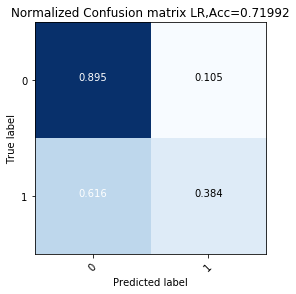

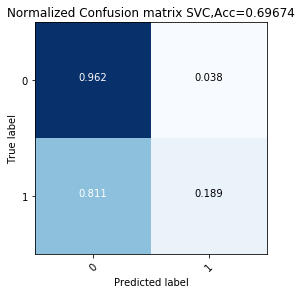

0.71992
0.69674


In [18]:
X_test=data_test.drop('Y',1)
Y_test=data_test.Y
Y_pred_LogiR=LogiR.predict(X_test)
Y_pred_LogiRProba=LogiR.predict_proba(X_test)
Y_pred_SVC=SVCla.predict(X_test)
Y_pred_SVCProba=SVCla.predict_proba(X_test)#probability of get class 0 or 1
# Compute confusion matrix
cnf_matrix_LR = confusion_matrix(Y_test, Y_pred_LogiR,labels=range(2))
cnf_matrix_SVC=confusion_matrix(Y_test, Y_pred_SVC,labels=range(2))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_LR, classes=range(2) ,normalize=True,title='Normalized Confusion matrix LR')
plt.show()
plot_confusion_matrix(cnf_matrix_SVC, classes=range(2) ,normalize=True,title='Normalized Confusion matrix SVC')
plt.show()
print(LogiR.score(X_test,Y_test))
print(SVCla.score(X_test,Y_test))

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #Student input code here
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], color='navy', lw=2,linestyle= '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc


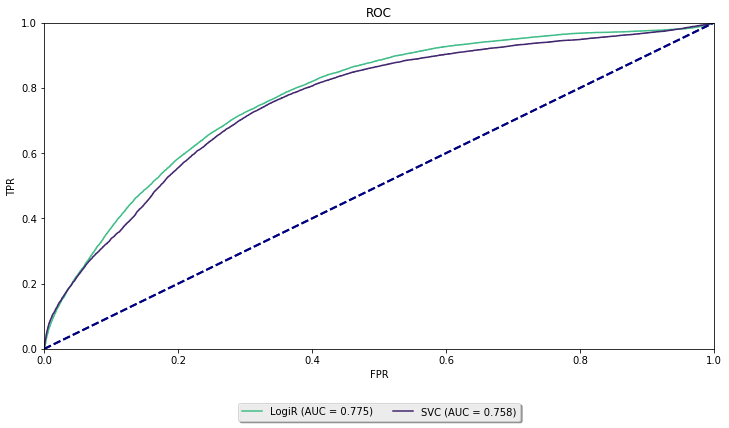

In [20]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC

#Student put code here
feature_auc_dict = {}
feature_auc_dict[LogiR] = plotUnivariateROC(Y_pred_LogiRProba[:,1], Y_test, 'LogiR')
feature_auc_dict[SVC] = plotUnivariateROC(Y_pred_SVCProba[:,1], Y_test, 'SVC')


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

<font face='Black' size=5>Answer:</font><br>
Based on the score function, LogisticRegression model is a little better than SVC. However, the SVC model has higher True Negative Rate (i.e. True Positive when predicting the 's' particle) and lower False Negative Rate. So when we need to predict the 's' particle's existance more accurately, we could consider using the SVC model.

### Part 3: Model selection with cross-validation (7 Points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 2000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Use sklearn.cross_validation.KFold to map each instance to a fold
- Performs two loops
  - Outer Loop: `for each fold in range(k)`:
    - Splits the data into `cv_train` & `cv_validate` according to previously defined fold mappings
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc_c_1,auc_c_2,..auc_c_k]` (i.e., for each c, we want a list full of auc's from each fold)

Note: Use Sklearn's KFold method, but do not use any other cross-validation convenience function. The goal is to learn how to implement the algorithm yourself!

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [21]:
#Don't forget to import any relevant libraries (i.e., sklearn.cross_validation)
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold

def xValSVM(dataset, label_name, k, cs):
    X=dataset.drop(label_name,1)
    Y=dataset[label_name]
    #print(Y)
    k_fold = KFold(dataset.shape[0], n_folds = k)
    aucs={}
    for j, (train, test) in enumerate(k_fold):
        #print(X.loc[100000+train,:])
        for c in cs:
            SVCts=SVC(C=c,kernel='linear',probability=True)
            tx=X.loc[100000+train,:]
            ty=Y.loc[100000+train] #Y is 1-dimensional!!
            rx=X.loc[100000+test,:]
            ry=Y.loc[100000+test]
            SVCts.fit(tx,ty)
            fpr, tpr, thresholds = roc_curve(ry, SVCts.predict_proba(rx)[:,1])
            roc_auc = auc(fpr, tpr)
            new_auc='AUC_{}_{}'.format(c,j)#name of auc
            aucs[new_auc]=roc_auc
    #lr_grid_search = GridSearchCV(LogisticRegression(), param_grid_lr, cv = kfolds, scoring = 'roc_auc') 
    #lr_grid_search.fit(X, Y)
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1, inclusive).
2.	Call aucs = xValSVM(data_train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) (don't forget, standard error of the mean of X is sqrt(Var(X)/N)
4.	Compute the value for max_1std = (mean(AUC)-StdErr(AUC)) associated with the c having max(mean(AUC)). I.e., part of what we have been calling the '1 standard error rule'.
5.	Generate a plot with the following:
    -	Log10(c) on the x-axis
    -	1 series with mean(AUC) for each c
    -	1 series with mean(AUC)-2*stderr(AUC) for each c (use ‘k+’ as color pattern)
    -	1 series with mean(AUC)+2*stderr(AUC) for each c (use ‘k--‘ as color pattern)
    -	a reference line for max_1std (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

In [22]:
cs=np.array([10**(i) for i in range(-8,2,1)])
aucs=xValSVM(data_train, 'Y', 10, cs)

In [49]:
temp_auc=np.zeros(10)
auc_mean=np.zeros(10)
auc_stderr=np.zeros(10)
#max_1std=np.zeros(10)
for i in range(-8,2,1):
    for k in range(10):
        temp_auc[k]=aucs['AUC_{}_{}'.format(float(10**(i)),k)]
    auc_mean[i+8]=np.mean(temp_auc)
    auc_stderr[i+8]=math.sqrt(np.var(temp_auc)/10)
for i in range(10):
    print('%.5f '%auc_mean[i],end="")
for i in range(10):
    print('%.5f '%auc_stderr[i],end="")
max_1std=(auc_mean.max()-auc_stderr[auc_mean.argmax()])
print('max_mean=:%.5f '%auc_mean.max(),'max_1std=:%.5f '%max_1std)

0.68388 0.68344 0.68665 0.70399 0.70700 0.70857 0.73204 0.74466 0.74781 0.74765 0.00815 0.00821 0.00803 0.00681 0.00686 0.00681 0.00775 0.00845 0.00822 0.00824 max_mean=:0.74781  max_1std=:0.73959 


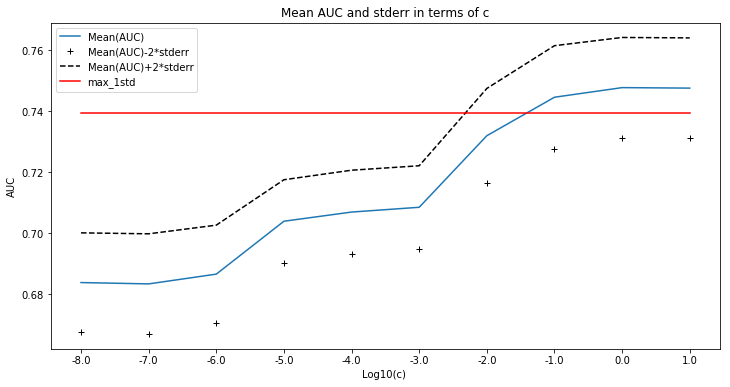

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax=plt.subplots(figsize=(12,6))
xplt=[i for i in range(10)]
xplt_out=np.zeros(10)
max1std=np.zeros(10)
max1std=max1std+max_1std
for i in range(10):
    xplt_out[i]=math.log10(cs[i])
ax.plot(xplt, auc_mean, label='Mean(AUC)')
ax.plot(xplt,auc_mean-2*auc_stderr,'k+',label='Mean(AUC)-2*stderr')
ax.plot(xplt,auc_mean+2*auc_stderr,'k--',label='Mean(AUC)+2*stderr')
ax.plot(xplt,max1std,'r',label='max_1std')
ax.set_xticks(xplt)
ax.set_xticklabels(xplt_out)
ax.set_ylabel('AUC')
ax.set_xlabel('Log10(c) ')
ax.set_title('Mean AUC and stderr in terms of c')
plt.legend()
plt.show()

answer here (verbal, no code):<br>
The model parameters selected did not beat the out-of-the-box model for SVM. With the method built above, the highest AUC is about 0.75 which is similar to that earned in former calculation with the default c.

### Part 4: Learning Curve with Bootstrapping (8 Points)

In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.

An example of using bootstrapping to build a learning curve can be found here: https://github.com/briandalessandro/DataScienceCourse/blob/master/ipython/python35/Lecture_ERM_LogReg_3.ipynb


1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). 
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples. Note: the standard error of the mean AUC is really the standard deviation of the bootstrapped distribution, so just use np.sqrt(np.var(...))


In [151]:
# Code here
'''def modBootstrapper(train, test, nruns, sampsize, lr, c):
    #X_train=data.drop('Y',1)
    #Y_train=data.Y
    X_test=test.drop('Y',1)
    Y_test=test.Y
    first_index=train.index[0]
    lenth_train=len(train)
    aucs={}#first col is mean, second is stderr
    for spsz in sampsize: #every sampsize spsz
        auc_temp=np.zeros(nruns)
        for j in range(nruns):
            indexnum=[numnum for numnum in range(spsz)]
            temp_train=pd.DataFrame(index=indexnum,columns=train.columns)
            for k in range(lenth_train):
                if k<spsz:
                    temp_train.loc[k,:]=train.loc[first_index+k,:]
                else:
                    judge=np.random.randint(k+2) #random int from
                    if judge>spsz:
                        ind_replace=np.random.randint(0,spsz)#from 0 to spsz choose a row to be replaced
                        temp_train.loc[ind_replace,:]=train.loc[first_index+k,:]
            X_train=temp_train.drop('Y',1)
            Y_train=temp_train.Y.astype('int64') #transform Y into int
            #print(Y_train)
            if lr==1:
                LR=LogisticRegression(C=1e30)
                LR.fit(X_train,Y_train)
                fpr, tpr, thresholds = roc_curve(Y_test, LR.predict_proba(X_test)[:,1])
                auc_temp[j] = auc(fpr, tpr)
            else:
                SC=SVC(C=c,kernel='linear',probability=True)
                SC.fit(X_train,Y_train)
                fpr, tpr, thresholds = roc_curve(Y_test, SC.predict_proba(X_test)[:,1])
                auc_temp[j] = auc(fpr, tpr)
        aucmean=np.mean(auc_temp)
        aucstderr=math.sqrt(np.var(auc_temp)/nruns)
        aucs[spsz]=(aucmean,aucstderr)
    return aucs'''
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    #X_train=data.drop('Y',1)
    #Y_train=data.Y
    X_test=test.drop('Y',1)
    Y_test=test.Y
    first_index=train.index[0]
    lenth_train=len(train)
    aucs={}#first col is mean, second is stderr
    for spsz in sampsize: #every sampsize spsz
        auc_temp=np.zeros(nruns)
        for j in range(nruns):
            indexnum=[numnum for numnum in range(spsz)]
            temp_train=pd.DataFrame(index=indexnum,columns=train.columns)
            for k in range(spsz):
                temp_train.loc[k,:]=train.loc[np.random.randint(lenth_train)+first_index,:]
            X_train=temp_train.drop('Y',1)
            Y_train=temp_train.Y.astype('int64') #transform Y into int
            #print(Y_train)
            if lr==1:
                LR=LogisticRegression(C=1e30)
                LR.fit(X_train,Y_train)
                fpr, tpr, thresholds = roc_curve(Y_test, LR.predict_proba(X_test)[:,1])
                auc_temp[j] = auc(fpr, tpr)
            else:
                SC=SVC(C=c,kernel='linear',probability=True)
                SC.fit(X_train,Y_train)
                fpr, tpr, thresholds = roc_curve(Y_test, SC.predict_proba(X_test)[:,1])
                auc_temp[j] = auc(fpr, tpr)
        aucmean=np.mean(auc_temp)
        aucstderr=math.sqrt(np.var(auc_temp)/nruns)
        aucs[spsz]=(aucmean,aucstderr)
    return aucs

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs). For SVM, use the value of C identified using the 1 standard error method from part 3. For LR, use the default C.

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each samp size (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each samp size (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


In [152]:
samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]
#samplesizes = [1500]
aucsSVC=modBootstrapper(data_train, data_test, nruns=20, sampsize=samplesizes, lr=0, c=1)
aucsLR=modBootstrapper(data_train, data_test, nruns=20, sampsize=samplesizes, lr=1, c=1)

E:\Programming\Anaconda\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [153]:
print('SVC:',aucsSVC)
print('LR:',aucsLR)

SVC: {50: (0.64247962425326954, 0.033658957747565325), 100: (0.68007044460270727, 0.022138365078978216), 200: (0.71827039431858075, 0.005817353847025347), 500: (0.73773290811279391, 0.005027674687031856), 1000: (0.75141400001165048, 0.0016973432218478856), 1500: (0.75221058684951592, 0.0018463805661887382), 2000: (0.7500031878268183, 0.0025526976569012227)}
LR: {50: (0.6824760888014425, 0.015513744127783167), 100: (0.72118118535030296, 0.007347134947608711), 200: (0.75214384281230873, 0.00202485587732817), 500: (0.76357661932974508, 0.0013539235392651815), 1000: (0.77025974592480861, 0.000836997591921433), 1500: (0.77058545999184991, 0.0006578687920971696), 2000: (0.77216755186172903, 0.0004211390564146651)}


In [154]:
aucsSVC_ar=np.zeros(len(aucsSVC)*2).reshape((len(aucsSVC),2))
aucsLR_ar=np.zeros(len(aucsLR)*2).reshape((len(aucsSVC),2))
k=0
for (i) in (aucsSVC.values()):
    aucsSVC_ar[k,:]=i[:]
    k=k+1
k=0
for (i) in (aucsLR.values()):
    aucsLR_ar[k,:]=i[:]
    k=k+1

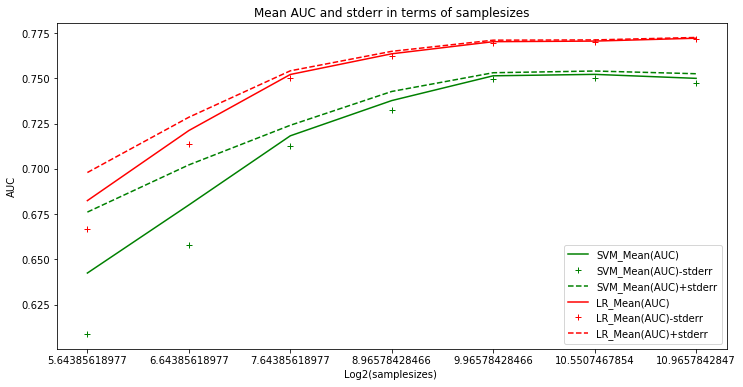

In [155]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax=plt.subplots(figsize=(12,6))
xplt=[i for i in range(7)]
xplt_out=np.zeros(7)
for i in range(7):
    xplt_out[i]=math.log2(samplesizes[i])
ax.plot(xplt,aucsSVC_ar[:,0],'g',label='SVM_Mean(AUC)')
ax.plot(xplt,aucsSVC_ar[:,0]-aucsSVC_ar[:,1],'g+',label='SVM_Mean(AUC)-stderr')
ax.plot(xplt,aucsSVC_ar[:,0]+aucsSVC_ar[:,1],'g--',label='SVM_Mean(AUC)+stderr')
ax.plot(xplt,aucsLR_ar[:,0],'r',label='LR_Mean(AUC)')
ax.plot(xplt,aucsLR_ar[:,0]-aucsLR_ar[:,1],'r+',label='LR_Mean(AUC)-stderr')
ax.plot(xplt,aucsLR_ar[:,0]+aucsLR_ar[:,1],'r--',label='LR_Mean(AUC)+stderr')
ax.set_xticks(xplt)
ax.set_xticklabels(xplt_out)
ax.set_ylabel('AUC')
ax.set_xlabel('Log2(samplesizes) ')
ax.set_title('Mean AUC and stderr in terms of samplesizes')
plt.legend()
plt.show()

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


answer here:<br>
The Logistic Regression algorithm is more suitable for smaller sample sizes. Although the SVM somehow catches up with LR as the samplesize grows up to 1000, LR has significant higher accuracy in predicting Y when samplesize is around 100. Since the curves tend to be stable when samplesize is larger than 1000, it is not worthy to invest twice the price to get more data.

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?



answer here:<br>
Based on ESL figure 7.8, with the decrease of the training set size, the 1-stderr will decrease significantly when the training set is smaller than 50. Although the bias of cross-validation can be ignored when training set is larger than 200, this algorithm could be biased upward if the total training set size is 50, since the actual training size in each training is(K-1)/K*50 in K-fold case, smaller than the actual size with a smaller 1-stderr.